In [1]:
import numpy as np
import pylab as pl
import matplotlib.gridspec as gridspec
from glob import glob
import tensorflow as tf
import numpy.ma as ma
import sys,os
from datetime import datetime, timedelta
import myfunc.util as util
from collections import deque
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
def mk_daylist(days=None, rat_train=1.0):
    nall   = days
    ntrain = int(nall*rat_train)
    np.random.seed(0)

    a1idx = range(nall)
    a1idx = np.random.choice(a1idx, len(a1idx), replace=False)
    a1idx_train = a1idx[:ntrain]
    a1idx_valid = a1idx[ntrain:]

    return a1idx_train,a1idx_valid


def read_Tc(lDTime=None, ldydx=None, isurf=None):
    a2tc = deque([])
    for DTime in lDTime:
        Year,Mon,Day = DTime.timetuple()[:3]
        a2tcTmp = None
        for idydx,(dy,dx) in enumerate(ldydx):
            #srcDir = '/work/hk01/utsumi/PMM/stop/data/Tc/%04d/%02d/%02d'%(Year,Mon,Day)
            srcDir = '/mnt/j/PMM/stop/data/Tc/%04d/%02d/%02d'%(Year,Mon,Day)
            srcPath1=srcDir + '/Tc1.%ddy.%ddx.%02dsurf.npy'%(dy,dx,isurf)
            srcPath2=srcDir + '/Tc2.%ddy.%ddx.%02dsurf.npy'%(dy,dx,isurf)
            if not os.path.exists(srcPath1): continue
            atc1 = np.load(srcPath1)
            atc2 = np.load(srcPath2)
            atc  = np.c_[atc1, atc2]

            try:
                a2tcTmp = np.c_[a2tcTmp, atc]
            except ValueError:
                a2tcTmp = atc

        if a2tcTmp is None:
            continue
        else:
            a2tcTmp = np.array(a2tcTmp)
        #**********************
        a2tc.extend(a2tcTmp)

    return np.array(a2tc)

def read_var_collect(varName=None, lDTime=None, ldydx=None, isurf=None):
    a2var = deque([])
    for DTime in lDTime:
        Year,Mon,Day = DTime.timetuple()[:3]
        a2varTmp = None
        for idydx,(dy,dx) in enumerate(ldydx):
            #srcDir = '/work/hk01/utsumi/PMM/stop/data/Tc/%04d/%02d/%02d'%(Year,Mon,Day)
            srcDir = '/mnt/j/PMM/stop/data/%s/%04d/%02d/%02d'%(varName,Year,Mon,Day)
            srcPath=srcDir + '/%s.%ddy.%ddx.%02dsurf.npy'%(varName,dy,dx,isurf)
            if not os.path.exists(srcPath): continue
            avar = np.load(srcPath)

            try:
                a2varTmp = np.c_[a2varTmp, avar]
            except ValueError:
                a2varTmp = avar

        if a2varTmp is None:
            continue
        else:
            a2varTmp = np.array(a2varTmp)
        #**********************
        a2var.extend(a2varTmp)
    return np.array(a2var)

def read_pc_coef(isurf):
    #*********************************
    # Read PC coefficient
    #*********************************
    #coefDir = '/work/hk01/utsumi/PMM/stop/data/coef'
    coefDir = '/mnt/j/PMM/stop/data/coef'
    egvecPath = coefDir + '/egvec.%02dch.%03dpix.%02dsurf.npy'%(ntc1+ntc2, len(ldydx),isurf)
    egvalPath = coefDir + '/egval.%02dch.%03dpix.%02dsurf.npy'%(ntc1+ntc2, len(ldydx),isurf)
    varratioPath = coefDir + '/varratio.%02dch.%03dpix.%02dsurf.npy'%(ntc1+ntc2, len(ldydx),isurf)
    
    a2egvec = np.load(egvecPath)  # (n-th, ncomb)
    a1varratio = np.load(varratioPath)
    a1cumvarratio= np.cumsum(a1varratio)
    return a2egvec, a1varratio, a1cumvarratio

def my_unit(x,Min,Max):
    return (x-Min)/(Max-Min)


print 'Define functions'

ldy   = [-1,0,1]
ldx   = [-3,-2,-1,0,1,2,3]
#ldx   = [-2,-1,0,1,2]
imid  = int((len(ldy)*len(ldx)-1)/2)
ldydx = [[dy,dx] for dy in ldy for dx in ldx]
isurf = 1
ldays_train,ldays_valid = mk_daylist(days=31, rat_train=0.2)
lDTime_train = [datetime(2017,1,1)+timedelta(days=i) for i in ldays_train]
lDTime_valid = [datetime(2017,1,1)+timedelta(days=i) for i in ldays_valid]


trainTc   = read_Tc(lDTime_train, ldydx, isurf)
trainStop = read_var_collect('stop', lDTime_train, ldydx, isurf)
trainLat  = read_var_collect('Latitude', lDTime_train, [[0,0]], isurf)

print trainTc.shape, trainStop.shape, trainLat.shape

Define functions
(179239, 273) (179239, 21) (179239,)


In [3]:
#latmin = -30
#latmax = 30
latmin=-90
latmax=-20

index_keep = []
for i in range(trainTc.shape[0]):
    lat = trainLat[i]
    if (latmin<=lat)and(lat<=latmax):
        index_keep.append(i)
print len(index_keep)
trainTc   = trainTc[index_keep]
trainStop = trainStop[index_keep]
trainLat  = trainLat[index_keep]
print trainTc.shape, trainStop.shape, trainLat.shape

75874
(75874, 273) (75874, 21) (75874,)


In [4]:
nstorm = 1
#nstorm = 21
nostorm = len(ldy)*len(ldx)-nstorm
if nstorm >1:
    a1flagstop = ((trainStop>=0).sum(axis=1) >=nstorm)
    trainTc   = trainTc[a1flagstop]
    trainStop = trainStop[a1flagstop]
trainTc.shape, trainStop.shape
trainStop = trainStop[:,imid].reshape(-1,1)
print trainTc.shape, trainStop

(75874, 273) [[1506.4084]
 [1671.7852]
 [2204.2183]
 ...
 [2432.14  ]
 [1643.8267]
 [1565.1613]]


In [5]:
# PC parameters
restriction = 10
#restriction = 20
#amean = trainTc.mean(axis=0)
#astd  = trainTc.std(axis=0)
#pca = PCA(n_components=restriction)
#pca.fit((trainTc-trainTc.mean(0))/trainTc.std(0))
#a2egvec=pca.components_
##a1egval=pca.explained_variance
#a1varratio=pca.explained_variance_ratio_

#*** preprocess parameters *******
Mon=1
preptype = 'nynx.%dx%d.isurf.%d.Mon.%d.Lat.%d.%d'%(len(ldy),len(ldx),isurf,Mon,latmin,latmax)
paramDir = '/mnt/j/PMM/stop/prep-param/%s'%(preptype)

#*** Tc mean, std *******
meanPath = paramDir + '/mean.Tc.npy'
stdPath  = paramDir + '/std.Tc.npy'
ameanTc = np.load(meanPath)
astdTc  = np.load(stdPath)

#*** PC coefficient (eigen vector)
egvecPath = paramDir + '/egvec.npy'
varratioPath = paramDir + '/varratio.npy'
a2egvec   = np.load(egvecPath)
a1varratio= np.load(varratioPath)

#*** PC min, max ***************
minPath = paramDir + '/pc.min.npy'
maxPath = paramDir + '/pc.max.npy'
MinPC   = np.load(minPath)
MaxPC   = np.load(maxPath)

In [6]:
# resample
resample_rate = 1.0
N = int(trainTc.shape[0]*resample_rate)
aidx = np.random.choice(np.arange(trainTc.shape[0]), N).astype('int32')
trainTc  = trainTc[aidx,:]
trainStop= trainStop[aidx,:]
print trainTc.shape, trainStop.shape

(75874, 273) (75874, 1)


In [7]:
trainTc
trainTc = (trainTc-ameanTc)/astdTc
#reduction = np.dot(trainTc, a2egvec[:restriction,:].T)
reduction = np.dot(trainTc, a2egvec[:restriction,:].T)

In [8]:
#Max = [ np.max(Glabel[i]) for i in range(14) ]
#Min = [ np.min(Glabel[i]) for i in range(14) ]
#Max =  np.max(trainStop)
#Min =  np.min(trainStop)
MinStop = 0
MaxStop = 32000
#MinRed, MaxRed = -590, 1929

print reduction.min(),reduction.max()

def unit(x):
    return ( x - np.min(x,0) )/( np.max(x,0) - np.min(x,0) )

-590.8039 1928.887


In [9]:
aidx = np.random.choice(np.arange(len(trainStop)), len(trainStop))
nTrain = int(len(aidx)*0.9)
aidxTrain = aidx[:nTrain]
aidxTest  = aidx[nTrain:]

print trainStop.shape
print nTrain
print reduction.shape
#trainX = unit(reduction)
#trainY = unit(trainStop)
trainX = my_unit(reduction,MinPC,MaxPC)
#trainX = unit(reduction)
trainY = my_unit(trainStop,MinStop,MaxStop)

print MinPC
print MaxPC
print 'reduction=',reduction
print 'reduction.min, max',reduction.min(), reduction.max()
print 'trainX.min, max', trainX.min(), trainX.max()
testX = trainX[aidxTest]
testY = trainY[aidxTest]
trainX= trainX[aidxTrain]
trainY= trainY[aidxTrain]

print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(75874, 1)
68286
(75874, 10)
[  -7.6241674 -311.9865    -590.8039      -4.838833    -6.9321785
   -4.967272    -1.7738361   -6.125675    -1.6694157   -2.6868188]
[1928.887      312.78076    655.85126     59.598923    24.301626
    5.588452     3.46699      4.45609      6.349144     3.5090547]
reduction= [[ 1.4946570e+00  3.0250823e-01 -7.6269859e-01 ... -5.5985558e-01
  -2.1688482e-01 -1.5232746e-02]
 [-2.3158023e+00 -2.2444308e-02  5.5495542e-01 ...  9.5149338e-02
  -1.8273526e-01 -3.0720171e-01]
 [ 2.0863867e+00  5.0003833e-01 -7.9606992e-01 ...  8.0103755e-02
  -5.7830840e-02 -4.9700737e-03]
 ...
 [-1.2895434e+00 -5.3783357e-03  1.7230482e-01 ...  2.2756007e-01
  -1.4739701e-01  1.9831875e-01]
 [-5.2720971e+00 -4.3868393e-01  1.5894618e+00 ...  2.5752592e-01
   9.3388206e-01 -3.4726956e-01]
 [-3.6263227e-01  1.4391288e-01 -1.6575724e-01 ... -6.4598382e-02
  -1.4573570e-01 -1.9713551e-01]]
reduction.min, max -590.8039 1928.887
trainX.min, max 0.0 1.0
((68286, 10), (68286, 1), (7588, 

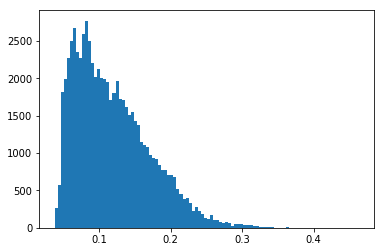

In [12]:
pl.subplot(111)
_,_,_ = pl.hist(trainY, 100)

In [13]:
def Figure(Label, Prediction, bins):
    Min,Max = MinStop, MaxStop
    recover_testY = (Max-Min)*Label.flatten()      + Min
    recover_pred  = (Max-Min)*Prediction.flatten() + Min

    pl.figure(figsize=(15,15))
    gs = gridspec.GridSpec(2,2, width_ratios=[1,1], height_ratios=[1,1])
    
    pl.subplot(gs[0,:])
    pl.plot(recover_testY/1000., c='r', label ='Observation')
    pl.plot(recover_pred /1000., c='b', label ='Prediction')
    pl.ylabel('height(km)')
    pl.ylim([0,18])
    pl.legend()
    pl.title('non-storm<=%d b=%d lat=[%.1f, %.1f] box=%dx%d'%(nostorm, bpara,latmin, latmax, len(ldy),len(ldx)))
    print('RMSE:'     , np.round(rmse(Label, Prediction) , 4))
    print('real RMSE:', np.round(Rmse(Label, Prediction) , 4))
    print('CC:'       , np.round(  cc(Label, Prediction) , 4))
    
    pl.subplot(gs[2]) # values prediction and testY are between -4 and 4
    aa = recover_pred
    bb = recover_testY
    interval           = np.array([ Min + (Max - Min)/bins*i for i in range(bins+1) ])
    interval1          = np.array([ Min + (Max - Min)/bins*i for i in range(bins+1) ])
    revised_interval   = interval[:-1]  + (Max - Min)/(2*bins)
    revised_interval1  = interval1[:-1] + (Max - Min)/(2*bins)
    cumulative_number  = []
    cumulative_number1 = []
    for i in range(bins):
        cumulative_number.append(  (aa < interval[i+1] ).sum() - (aa < interval[i] ).sum() )
        cumulative_number1.append( (bb < interval1[i+1]).sum() - (bb < interval1[i]).sum() )
    pl.plot(revised_interval/.1000          , cumulative_number   , color='green', alpha=0.5, label='Prediction')    
    pl.fill_between(revised_interval/.1000  , cumulative_number, 0, color='green', alpha=0.5)
    pl.plot(revised_interval1/.1000         , cumulative_number1  , color='red'  , alpha=0.5 ,label='Observation')    
    pl.fill_between(revised_interval1/.1000 ,cumulative_number1, 0, color='red'  , alpha=0.5)
    pl.ylabel('number of samples')
    pl.xlabel('height(km)')
    pl.legend() 
    pl.title('Distribution')
    pl.legend()

    #*** 2D histogram **********
    H,xbnd,ybnd = np.histogram2d(recover_testY/1000, recover_pred/1000, bins=[np.arange(0,20,0.5), np.arange(0,20,0.5)])
    H = ma.masked_equal(H,0)
    X,Y = np.meshgrid(xbnd,ybnd)
    pl.subplot(gs[3])
    pl.pcolormesh(X,Y,H.T, cmap='jet')
    pl.axis([0,18,0,18])
    pl.xticks([0,5,10,15])
    pl.yticks([0,5,10,15])
    pl.plot([0,35],[0,35],'k')
    pl.xlabel('Observation(km)')
    pl.ylabel('Prediction(km)')
    pl.title('Correlation')
    pl.grid()
    pl.colorbar()
    
    #pl.scatter(recover_testY/1000, recover_pred/1000,s=3)
    #pl.plot(np.arange(18000)/1000,np.arange(18000)/1000,c='black',linestyle = ':')
    #pl.axis([0,18,0,18])
    #pl.xticks([0,5,10,15])
    #pl.yticks([0,5,10,15])
    #pl.xlabel('Observation(km)')
    #pl.ylabel('Prediction(km)')
    #pl.title('Correlation')
    #pl.grid()

In [14]:
bpara  = 5
degree = 12
coef_b = bpara
#coef_poly  = mk_coef_polyfit(testY, degree, coef_b)

In [15]:
## Apply error function
##Train, Label = unit(reduction), unit(label)
##ntrain       = int(0.7*len(reduction))
#print(trainX.shape, trainY.shape, testX.shape, testY.shape)
##dim = [trainX.shape[2], 30, 30, 30,10, trainY.shape[1]]
#dim = [trainX.shape[1], 30, 30, 30,10, trainY.shape[1]]
#act = 2
#expr= 'surf%d.b%d.lat.%d.%d'%(isurf,bpara,latmin,latmax)
#prediction   = FFN(trainX, trainY, testX, testY, 0.005, 50, 1024*4, dim, act)
##prediction   = FFN(trainX, trainY, testX, testY, 0.005, 150, 1024*4, dim, act)

In [16]:

#**** Checkpoints **********************
expr= 'surf%d.b%d.lat.%d.%d'%(isurf,bpara,latmin,latmax)
#ckptDir = '/work/hk01/utsumi/PMM/stop/ml-param-%d'%(act)
ckptDir = '/mnt/j/PMM/stop/ml-param/%s'%(expr)
ckptPath= ckptDir + '/stop.%02d'%(isurf)
#******************************** 
print testX.shape
with tf.Session() as sess:
    saver = tf.train.import_meta_graph(ckptPath + '.meta')
    saver.restore(sess, tf.train.latest_checkpoint(ckptDir + '/'))
    graph = tf.get_default_graph()
    X      = graph.get_tensor_by_name('input:0')
    pred   = graph.get_tensor_by_name('pred:0')
    print X
    print pred
    out    = sess.run(pred, feed_dict={X:testX})
print out.shape
prediction = out
print 'testX.min, max', testX.min(), testX.max()
print 'prediction.min(),max()',prediction.min(),prediction.max()

(7588, 10)
INFO:tensorflow:Restoring parameters from /mnt/j/PMM/stop/ml-param/surf1.b5.lat.-90.-20/stop.01
Tensor("input:0", shape=(?, 10), dtype=float32)
Tensor("pred:0", shape=(?, 1), dtype=float32)
(7588, 1)
testX.min, max 0.0 1.0
prediction.min(),max() 0.04385358 0.38043243


('RMSE:', 0.0341)
('real RMSE:', 1090.6001)
('CC:', 0.7698)


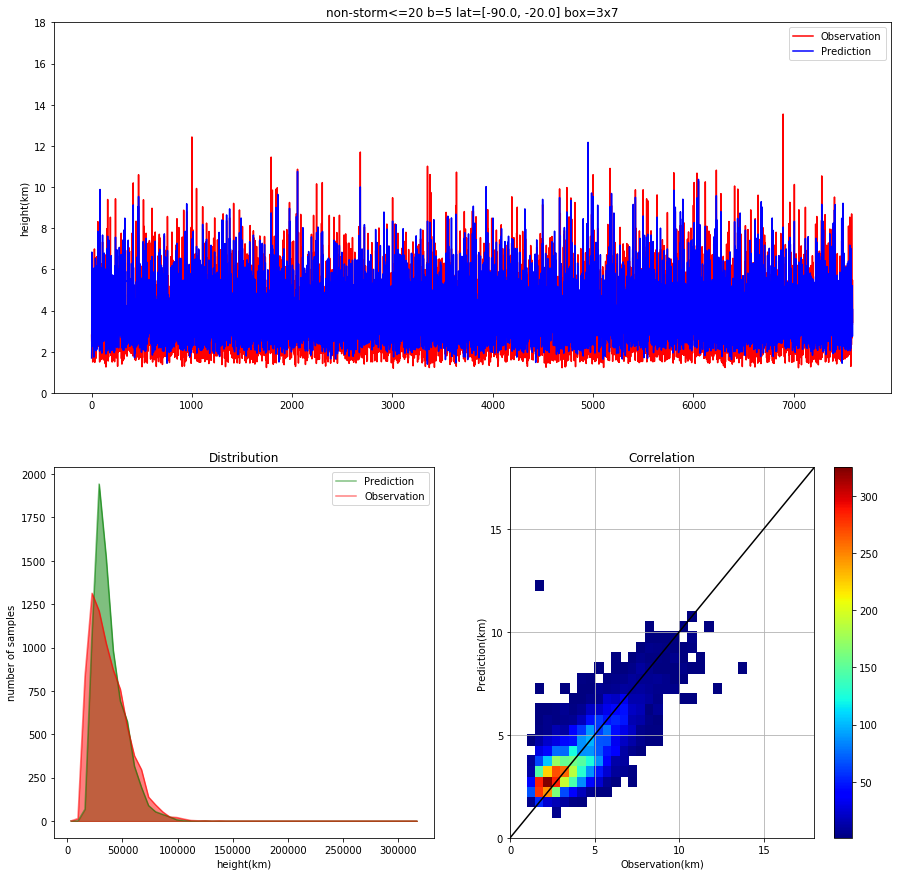

In [17]:
Figure(testY, prediction, 50)